* 6 models
    * 2 FC
    * 2 2D CNN
    * 2 3D CNN
    * Shouldn't overfit ( < 600k parameters )
* Visualize CNN kernels
    * Identify frequnecy bands that are being observed

In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pywt
from scipy import signal
from tqdm import tqdm

%matplotlib inline

## Load data

In [2]:
data_path = "Data/GeneratedData/combined_data/"
base_path = os.getcwd()

# REST
IDD = np.load(os.path.join(data_path, "IDD_rest.npy"))
TDC = np.load(os.path.join(data_path, "TDC_rest.npy"))

# MUSIC
# IDD = np.load(os.path.join(data_path, "IDD_music.npy"))
# TDC = np.load(os.path.join(data_path, "TDC_music.npy"))

X = np.concatenate((TDC, IDD))
Y = [0]*len(TDC) + [1]*len(IDD)
Y = np.asarray(Y)

In [3]:
print(X.shape)
print(Y.shape)

(8470, 14, 256)
(8470,)


## Create Spectrograms

In [4]:
# Modified scalogram function from Fusion notebook
def scalogram(x, Hz, hz, num_secs, w = 5.):
    ''' x = time series
        Hz = sampling rate in Hz of the input signal
        hz = desired sampling rate (by downsampling)
        start_sec = starting second in x
        num_secs = total number of seconds of our clip
        w = width parameter
        log =raw_seiz if true take log of spectrum values
    '''
    
    downsample = int(round(Hz / hz))
    X = x[0: num_secs * Hz : downsample]


    t, dt = np.linspace(0, num_secs, hz * num_secs, retstep = True)
    fs = 1 / dt

    freq = np.linspace(1, fs / 2, int(hz / 2))
    widths = w * fs / (2 * np.pi * freq)

    cwtm = signal.cwt(X,
                      signal.morlet2,
                      widths,
                      w = w)
    
    return cwtm

In [5]:
def generate_scalogram(data, Hz, hz, num_secs, w = 5.):
    scalogram_data = np.zeros((data.shape[0], data.shape[1] * (hz // 2), hz * num_secs), dtype="complex128")
    for sample_index in tqdm(range(data.shape[0])):
        for channel_index in range(0, data.shape[1]):
            scalogram_data[sample_index][channel_index * (hz//2): channel_index * (hz//2) + hz//2] = \
            scalogram(data[sample_index][channel_index], 128, 64, 2)
    return scalogram_data

In [6]:
X_scalogram = generate_scalogram(X, 128, 64, 2)

100%|██████████| 8470/8470 [04:22<00:00, 32.29it/s]


In [7]:
X_scalogram.shape

(8470, 448, 128)

In [97]:
def plot_scalogram(data, labels, sample_index, channel, N=128, hz=64, T=2, ts=0, w=4.):
    """
    :param N: signal sampling rate
    :param hz: downsampled sampling rate
    :param T: seconds
    :param ts: starting second
    :param w: 
    """

    t, dt = np.linspace(ts, ts + T, hz * T, retstep = True)
    fs = 1 / dt

    freq = np.linspace(1, (fs / 2), int(hz / 2))
    
    print("Y label:", labels[sample_index])
    
    plt.rcParams['figure.figsize'] = 12, 4
    x = np.arange(N)
    im = plt.pcolormesh(x, freq, np.abs(np.squeeze(data[sample_index][channel])), cmap = 'jet') # 'viridis'
#     plt.title("Scalogram for channel 4 of a TDC subject at rest")
    plt.show()


In [98]:
# reshape data
X_scalogram_shaped = X_scalogram.reshape(X_scalogram.shape[0], 14, 32, 128, 1)
X_scalogram_shaped.shape

(8470, 14, 32, 128, 1)

Y label: 0


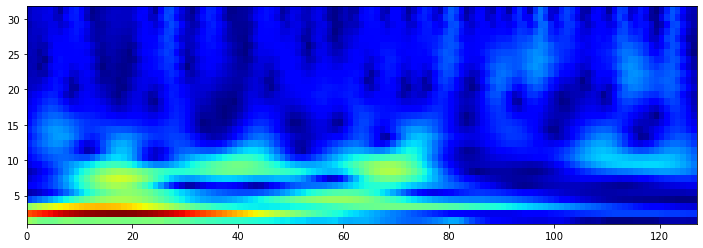

In [99]:
plot_scalogram(X_scalogram_shaped, Y, 2000, 4)

## Test-Train split

In [11]:
X_train, X_val, y_train, y_val = train_test_split(X_scalogram_shaped, Y, test_size=0.2, stratify=Y, random_state=42)

In [12]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)
input_shape = X_train.shape[1:]
print("input_shape: ", input_shape)

X_train shape: (6776, 14, 32, 128, 1)
y_train shape: (6776,)
X_val shape: (1694, 14, 32, 128, 1)
y_val shape: (1694,)
input_shape:  (14, 32, 128, 1)


## Model

In [13]:
def plot_history(history):
    # Retrieve a list of accuracy results on training and test data
    # sets for each training epoch
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    # Retrieve a list of list results on training and test data
    # sets for each training epoch
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    # Get number of epochs
    epochs = range(len(acc))
    plt.figure(figsize=(6.4,4.8))
    # Plot training and validation accuracy per epoch
    plt.plot(epochs, acc)
    plt.plot(epochs, val_acc)
    plt.title('Training and validation accuracy')
    plt.legend(['train', 'val'], loc='upper left')

    plt.figure(figsize=(6.4,4.8))

    # Plot training and validation loss per epoch
    plt.plot(epochs, loss)
    plt.plot(epochs, val_loss)
    plt.title('Training and validation loss')
    plt.legend(['train', 'val'], loc='upper left')

In [29]:
cnn_3d = keras.Sequential([
    # Set input layer
    keras.layers.InputLayer(input_shape=input_shape),
    
    # Conv + Maxpooling
    keras.layers.Conv3D(4, (5, 5, 5), padding="same", activation=tf.nn.relu),
    keras.layers.MaxPooling3D(pool_size=(2, 2, 2)),
    
    keras.layers.Conv3D(4, (5, 5, 5), padding="same", activation=tf.nn.relu),
    keras.layers.MaxPooling3D(pool_size=(2, 2, 2)),
    
    # Normalization
    keras.layers.BatchNormalization(),
    
    # Flatten to 1D
    keras.layers.Flatten(),
    
    keras.layers.Dense(8, activation=tf.nn.relu),
    
    keras.layers.Dropout(0.4),
    
    keras.layers.Dense(4, activation=tf.nn.relu),
    
    
    # Sigmoid
    keras.layers.Dense(1, activation=tf.nn.sigmoid)
])


In [30]:
cnn_3d.compile(
  optimizer='adam',
  loss='binary_crossentropy',
  metrics=['accuracy'],
)
cnn_3d.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_10 (Conv3D)           (None, 14, 32, 128, 4)    504       
_________________________________________________________________
max_pooling3d_10 (MaxPooling (None, 7, 16, 64, 4)      0         
_________________________________________________________________
conv3d_11 (Conv3D)           (None, 7, 16, 64, 4)      2004      
_________________________________________________________________
max_pooling3d_11 (MaxPooling (None, 3, 8, 32, 4)       0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 3, 8, 32, 4)       16        
_________________________________________________________________
flatten_5 (Flatten)          (None, 3072)              0         
_________________________________________________________________
dense_15 (Dense)             (None, 8)                

Train on 6776 samples, validate on 1694 samples
Epoch 1/5
6776/6776 [==============================] - 306s 45ms/sample - loss: 0.3956 - accuracy: 0.8458 - val_loss: 0.1303 - val_accuracy: 0.9852
Epoch 2/5
6776/6776 [==============================] - 272s 40ms/sample - loss: 0.0991 - accuracy: 0.9807 - val_loss: 0.0209 - val_accuracy: 0.9976
Epoch 3/5
6776/6776 [==============================] - 271s 40ms/sample - loss: 0.0700 - accuracy: 0.9866 - val_loss: 0.0061 - val_accuracy: 1.0000
Epoch 4/5
6776/6776 [==============================] - 268s 40ms/sample - loss: 0.0689 - accuracy: 0.9851 - val_loss: 0.0029 - val_accuracy: 1.0000
Epoch 5/5
6776/6776 [==============================] - 265s 39ms/sample - loss: 0.0647 - accuracy: 0.9882 - val_loss: 0.0011 - val_accuracy: 1.0000


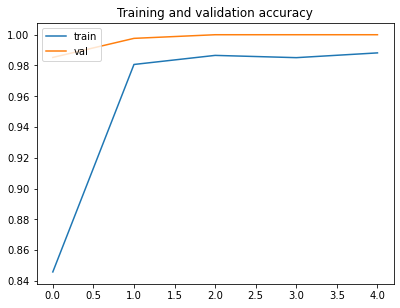

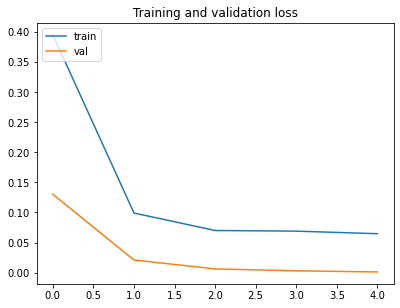

In [32]:
plot_history(cnn_3d.fit(X_train, 
                    y_train, 
                    epochs=5, 
                    batch_size=256,
                    validation_data=(X_val, y_val), 
                    verbose=1))


* Rest
    * Validation accuracy: 100%
    * Validation loss: 0.0011
* Music
    * Validation 


## Visualize Layers

In [33]:
from tensorflow.keras.models import Model
layer_outputs = [layer.output for layer in cnn_3d.layers]
for layer in layer_outputs:
    print(layer)
# feature_map_model = Model(inputs=complex_model.input, output=layer_outputs)
feature_map_model = Model(cnn_3d.input, layer_outputs)

Tensor("conv3d_10/Identity:0", shape=(None, 14, 32, 128, 4), dtype=float32)
Tensor("max_pooling3d_10/Identity:0", shape=(None, 7, 16, 64, 4), dtype=float32)
Tensor("conv3d_11/Identity:0", shape=(None, 7, 16, 64, 4), dtype=float32)
Tensor("max_pooling3d_11/Identity:0", shape=(None, 3, 8, 32, 4), dtype=float32)
Tensor("batch_normalization_5/Identity:0", shape=(None, 3, 8, 32, 4), dtype=float32)
Tensor("flatten_5/Identity:0", shape=(None, 3072), dtype=float32)
Tensor("dense_15/Identity:0", shape=(None, 8), dtype=float32)
Tensor("dropout_5/Identity:0", shape=(None, 8), dtype=float32)
Tensor("dense_16/Identity:0", shape=(None, 4), dtype=float32)
Tensor("dense_17/Identity:0", shape=(None, 1), dtype=float32)


In [34]:
# def display_activation(activations, col_size, row_size, layer, act_index): 
#     activation = activations[layer][0][act_index]
#     activation_index=0
#     fig, ax = plt.subplots(row_size, col_size, figsize=(row_size*8,col_size*8))
#     for row in range(0,row_size):
#         for col in range(0,col_size):
#             ax[row][col].imshow(activation[0, :, :, activation_index], cmap='jet')
#             activation_index += 1

In [83]:
def display_activation(activations, col_size, row_size, layer, channel): 
    activation = activations[layer][0][channel]
    activation_index=0
    fig, ax = plt.subplots(row_size, col_size, figsize=(row_size*8,col_size*3))
    for row in range(0,row_size):
        for col in range(0,col_size):
            ax[row][col].imshow(activation[:, :, activation_index], cmap='jet')
            activation_index += 1
            ax[row][col].invert_yaxis()

In [38]:
# activations = feature_map_model.predict(X_train[index].reshape(1,14,32,128,1))
# len(activations[0][0][0][0][0])
# shape: (10, 1, 14, 32, 128, 8)

Channel 0
Y label: 0


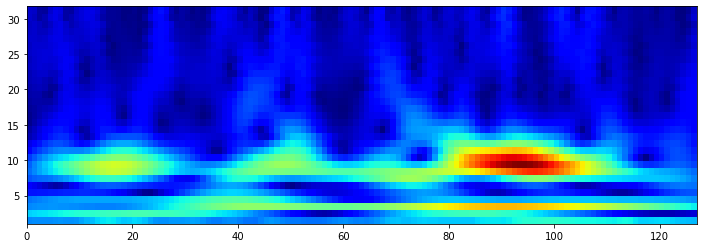

Channel 1
Y label: 0


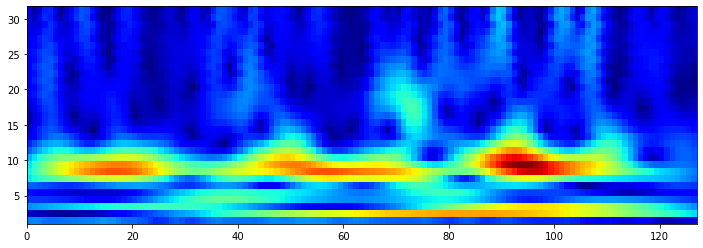

Channel 2
Y label: 0


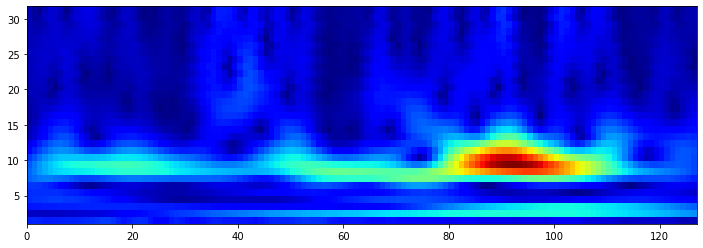

Channel 3
Y label: 0


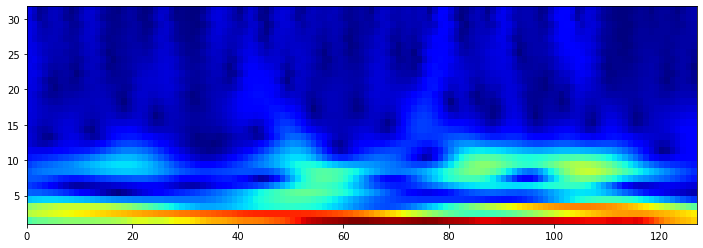

Channel 4
Y label: 0


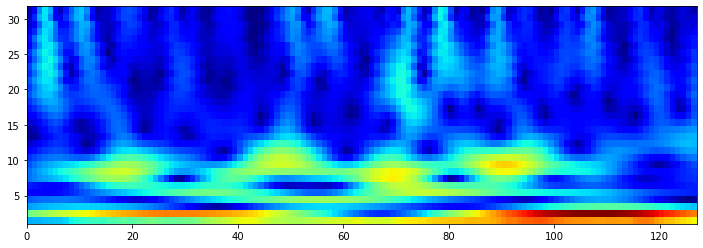

Channel 5
Y label: 0


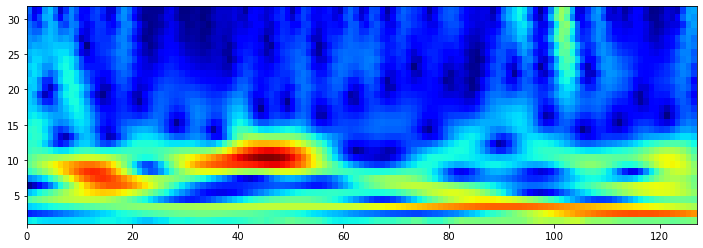

Channel 6
Y label: 0


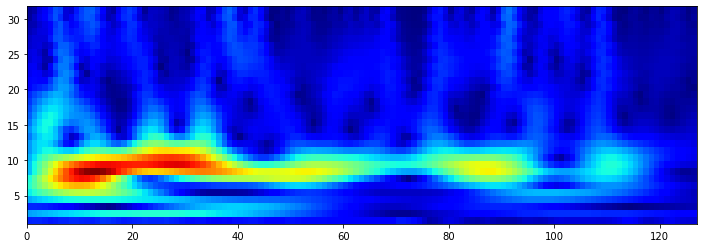

Channel 7
Y label: 0


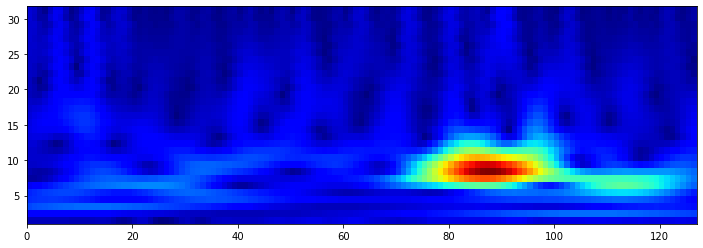

Channel 8
Y label: 0


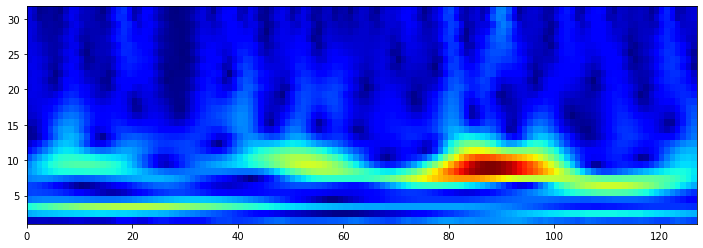

Channel 9
Y label: 0


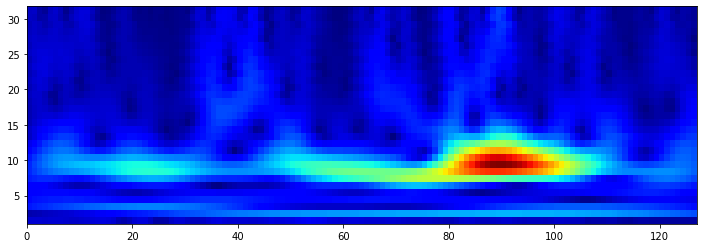

Channel 10
Y label: 0


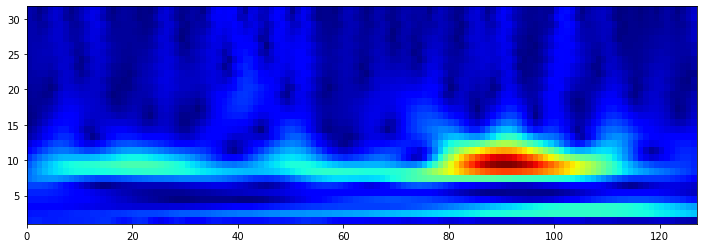

Channel 11
Y label: 0


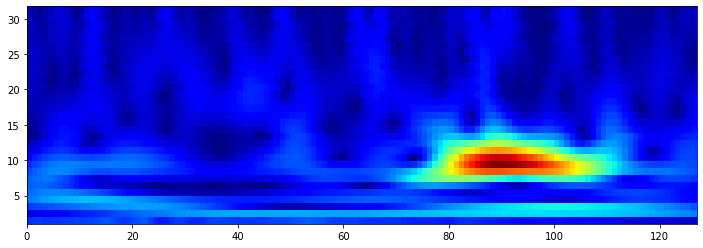

Channel 12
Y label: 0


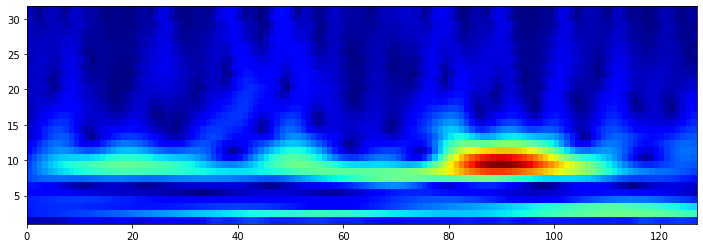

Channel 13
Y label: 0


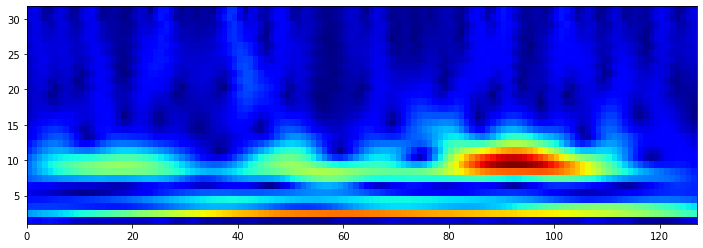

In [106]:
index = 4000

for i in range(14):
    print("Channel", i)
    plot_scalogram(X_train.reshape(6776, 14, 32, 128), y_train, index, i)


Channel 1
Y label: 0


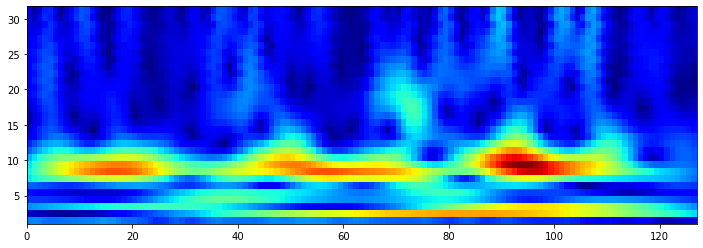

In [107]:
channel = 1
print("Channel", channel)
plot_scalogram(X_train.reshape(6776, 14, 32, 128), y_train, index, channel)

Label:  0
Prediction: 3.4598765e-05


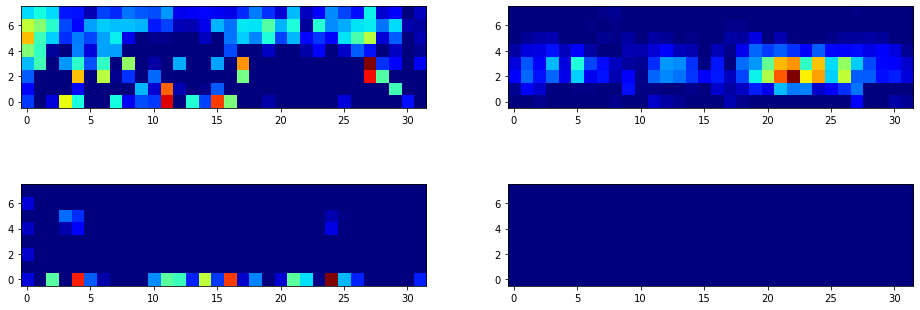

In [111]:
activations = feature_map_model.predict(X_train[index].reshape(1,14,32,128,1))
display_activation(activations, 2, 2, 3, channel)
print("Label: ", y_train[index])
print("Prediction:", activations[9][0][0])

Channel 0
Y label: 1


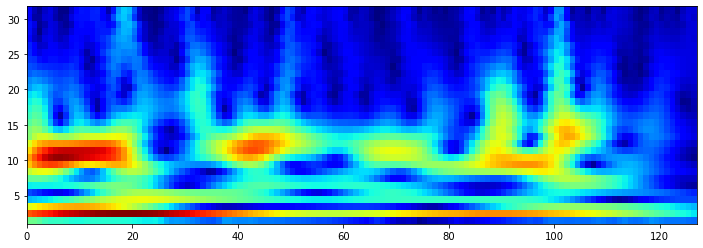

Channel 1
Y label: 1


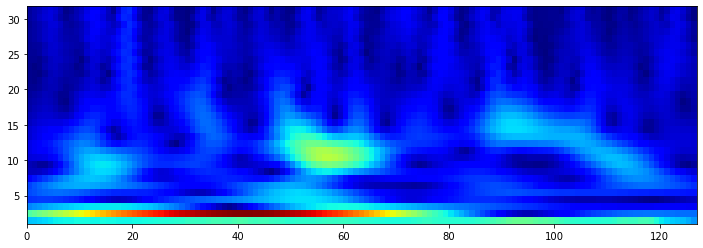

Channel 2
Y label: 1


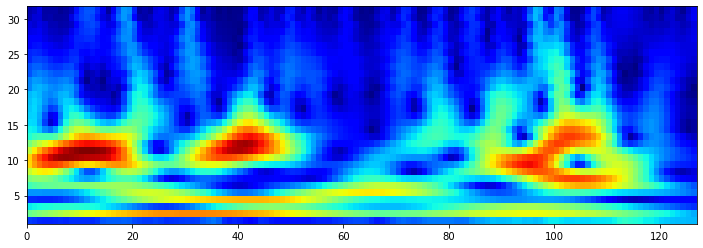

Channel 3
Y label: 1


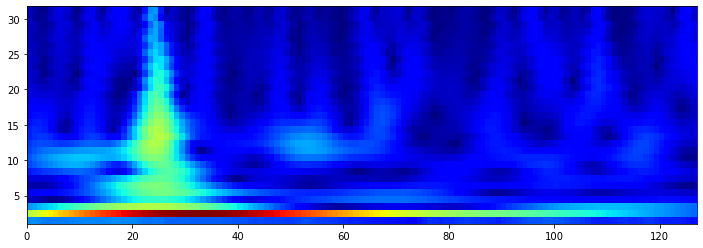

Channel 4
Y label: 1


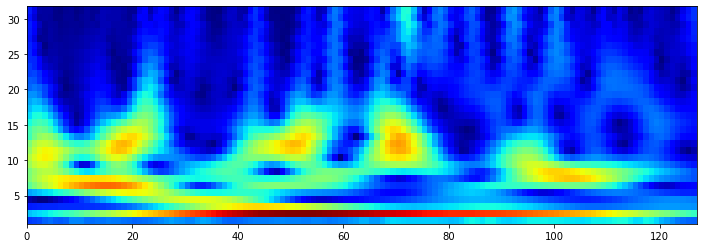

Channel 5
Y label: 1


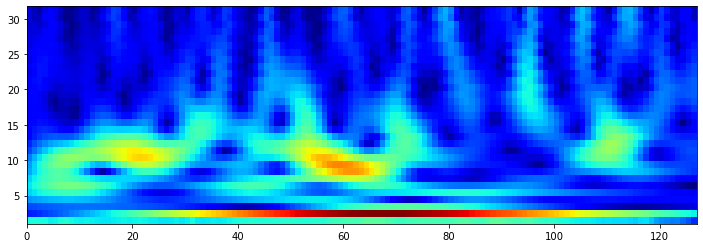

Channel 6
Y label: 1


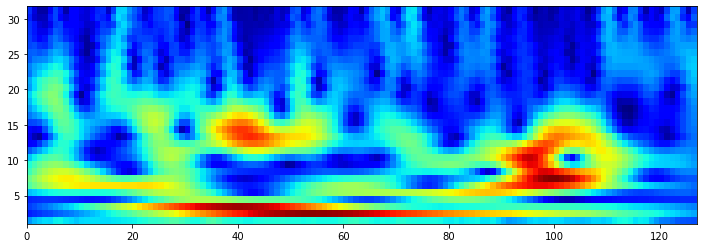

Channel 7
Y label: 1


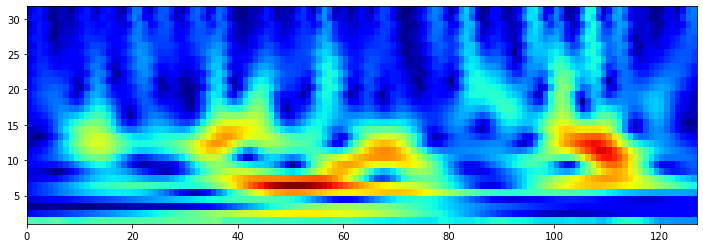

Channel 8
Y label: 1


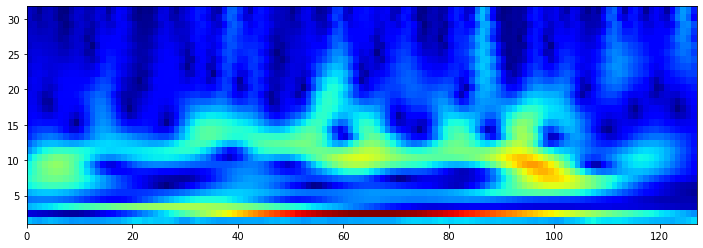

Channel 9
Y label: 1


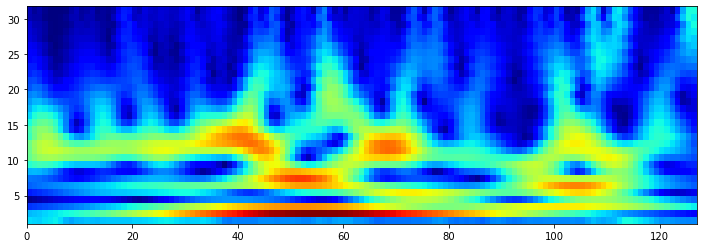

Channel 10
Y label: 1


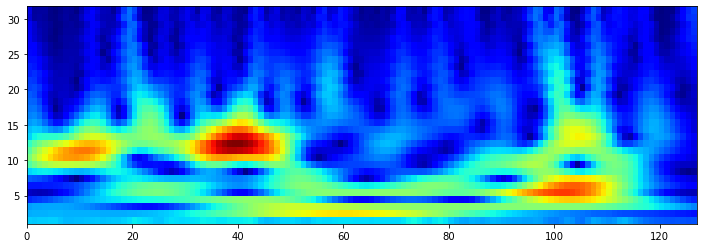

Channel 11
Y label: 1


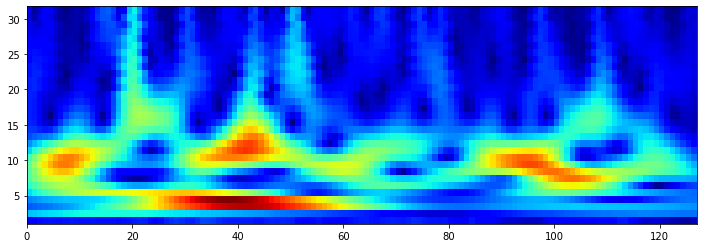

Channel 12
Y label: 1


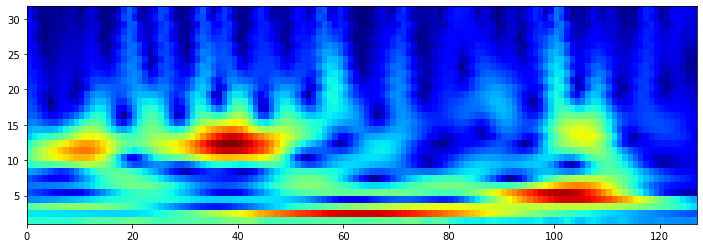

Channel 13
Y label: 1


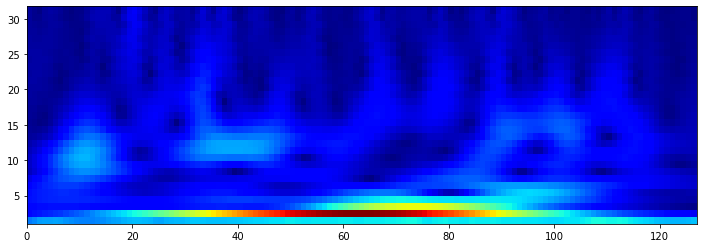

In [112]:
index = 5000

for i in range(14):
    print("Channel", i)
    plot_scalogram(X_train.reshape(6776, 14, 32, 128), y_train, index, i)


Channel 2
Y label: 1


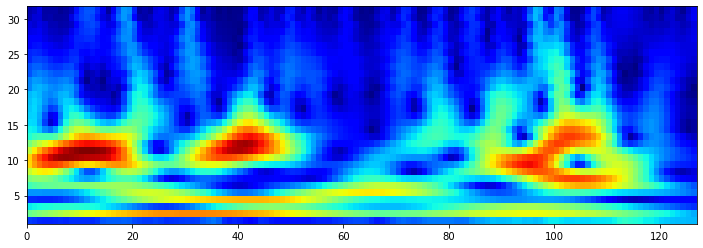

In [114]:
channel = 2
print("Channel", channel)
plot_scalogram(X_train.reshape(6776, 14, 32, 128), y_train, index, channel)

Label:  1


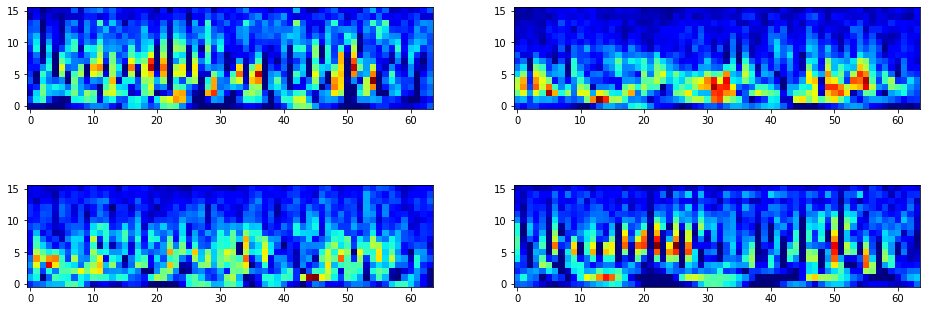

In [119]:
activations = feature_map_model.predict(X_train[index].reshape(1,14,32,128,1))
display_activation(activations, 2, 2, 1, channel)
print("Label: ", y_train[index])

In [118]:
X_train[0].shape

(448, 128, 1)